<a href="https://colab.research.google.com/github/structaAI/invigilAI/blob/master/final_malpractice_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Implementation-Malpractice Detection

### Installing Dependencies

In [2]:
%pip install ultralytics albumentations plotly wandb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.0 MB/s eta 0:00:00


In [3]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

### Imports

In [4]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import json
import yaml
from datetime import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import glob
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Checking PyTorch and CUDA dependencies

In [5]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: True


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class MalpracticeConfig:
  PROHIBITED_CLASSES = ['looking_sideways', 'turning_back', 'looking_up', 'phone', 'exchanging']
  ALLOWED_CLASSES = ['looking_forward', 'looking_down', 'paper']

  ALL_CLASSES = PROHIBITED_CLASSES + ALLOWED_CLASSES

  BATCH_SIZE = 16
  EPOCHS = 100
  IMG_SIZE = 640
  CONFIDENCE_THRESHOLD = 0.5

  PROHIBITED_WEIGHT = 1.0
  MALPRACTICE_THRESHOLD = 0.3

  DATASET_PATH = "/content/drive/MyDrive/Colab Datasets/Malpractice Detection.v1i.yolov8-obb"
  PROJECT_NAME = "malpractice-detection-v1"

config = MalpracticeConfig()

## Prepare Local Raw Data Staging Area

### Subtask:
Clear any previous dummy data and create the necessary local directories for raw images and labels within '/content/malpractice_dataset/raw_data'. This will be the temporary location for the unsplit data copied from Google Drive.


**Reasoning**:
To prepare the local data staging area as instructed, I will first remove any existing `/content/malpractice_dataset` directory to ensure a clean slate, then create the base directory `/content/malpractice_dataset/raw_data`, and finally create the `images` and `labels` subdirectories within `raw_data`.



In [7]:
import os
import shutil

base_dataset_dir = '/content/malpractice_dataset'
raw_data_dir = os.path.join(base_dataset_dir, 'raw_data')

if os.path.exists(base_dataset_dir):
    shutil.rmtree(base_dataset_dir)
    print(f"Removed existing directory: {base_dataset_dir}")

os.makedirs(raw_data_dir, exist_ok=True)
print(f"Created base raw data directory: {raw_data_dir}")

os.makedirs(os.path.join(raw_data_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(raw_data_dir, 'labels'), exist_ok=True)
print("Created 'images' and 'labels' subdirectories within raw_data.")

Created base raw data directory: /content/malpractice_dataset/raw_data
Created 'images' and 'labels' subdirectories within raw_data.


## Localizing Dataset

In [8]:
import os
import shutil

source_drive_images_dir = '/content/drive/MyDrive/Colab Datasets/Malpractice Detection.v1i.yolov8-obb/train/images'
source_drive_labels_dir = '/content/drive/MyDrive/Colab Datasets/Malpractice Detection.v1i.yolov8-obb/train/labels'

local_raw_images_dir = os.path.join(raw_data_dir, 'images')
local_raw_labels_dir = os.path.join(raw_data_dir, 'labels')

print(f"Copying images from: {source_drive_images_dir} to {local_raw_images_dir}")
print(f"Copying labels from: {source_drive_labels_dir} to {local_raw_labels_dir}")

if os.path.exists(source_drive_images_dir):
    for filename in os.listdir(source_drive_images_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            shutil.copy(os.path.join(source_drive_images_dir, filename),
                        os.path.join(local_raw_images_dir, filename))
    print(f"Copied {len(os.listdir(local_raw_images_dir))} image files.")
else:
    print(f"Source image directory not found: {source_drive_images_dir}")

if os.path.exists(source_drive_labels_dir):
    for filename in os.listdir(source_drive_labels_dir):
        if filename.endswith('.txt'):
            shutil.copy(os.path.join(source_drive_labels_dir, filename),
                        os.path.join(local_raw_labels_dir, filename))
    print(f"Copied {len(os.listdir(local_raw_labels_dir))} label files.")
else:
    print(f"Source label directory not found: {source_drive_labels_dir}")

print("Data copy complete.")

Copying images from: /content/drive/MyDrive/Colab Datasets/Malpractice Detection.v1i.yolov8-obb/train/images to /content/malpractice_dataset/raw_data/images
Copying labels from: /content/drive/MyDrive/Colab Datasets/Malpractice Detection.v1i.yolov8-obb/train/labels to /content/malpractice_dataset/raw_data/labels
Copied 140 image files.
Copied 140 label files.
Data copy complete.


In [22]:
import os
import shutil

# This cell was incorrectly attempting to copy files and is being removed.
# The primary data localization is handled by the preceding cell (090e7696)
# which copies the training split to a raw data staging area.
# The subsequent DatasetSplit class then correctly structures the dataset locally.

# source_drive_images_dir = config.DATASET_PATH
# source_drive_labels_dir = os.path.join(os.path.dirname(config.DATASET_PATH), 'labels')

# local_raw_images_dir = os.path.join(raw_data_dir, 'images')
# local_raw_labels_dir = os.path.join(raw_data_dir, 'labels')

# print(f"Copying images from: {source_drive_images_dir} to {local_raw_images_dir}")
# print(f"Copying labels from: {source_drive_labels_dir} to {local_raw_labels_dir}")

# if os.path.exists(source_drive_images_dir):
#     for filename in os.listdir(source_drive_images_dir):
#         if filename.endswith(('.jpg', '.jpeg', '.png')):
#             shutil.copy(os.path.join(source_drive_images_dir, filename),
#                         os.path.join(local_raw_images_dir, filename))
#     print(f"Copied {len(os.listdir(local_raw_images_dir))} image files.")
# else:
#     print(f"Source image directory not found: {source_drive_images_dir}")

# if os.path.exists(source_drive_labels_dir):
#     for filename in os.listdir(source_drive_labels_dir):
#         if filename.endswith('.txt'):
#             shutil.copy(os.path.join(source_drive_labels_dir, filename),
#                         os.path.join(local_raw_labels_dir, filename))
#     print(f"Copied {len(os.listdir(local_raw_labels_dir))} label files.")
# else:
#     print(f"Source label directory not found: {source_drive_labels_dir}")

# print("Data copy complete.")

In [18]:
def setup_dataset_structure():
  print("Setting up dataset structure...")

  required_folders = ['train', 'val', 'test']
  required_subfolders = ['images', 'labels']

  if not os.path.exists(config.DATASET_PATH):
    print(f"Dataset path not found: {config.DATASET_PATH}")
    print("Please upload your dataset to this location")
    return False

  for folder in required_folders:
    folder_path = os.path.join(config.DATASET_PATH, folder)
    if not os.path.exists(folder_path):
      print(f"Missing folder: {folder}")
      return False

    for subfolder in required_subfolders:
      subfolder_path = os.path.join(folder_path, subfolder)
      if not os.path.exists(subfolder_path):
        print(f"Missing subfolder: {subfolder_path}")
        return False

  yaml_path = os.path.join(config.DATASET_PATH, 'data.yaml')
  if not os.path.exists(yaml_path):
      print(f"Missing data.yaml file")
      return False

  print("Dataset structure validated!")
  return True

dataset_ready = setup_dataset_structure()

Setting up dataset structure...
Missing folder: val


In [20]:
# Call the analyze_dataset() function after the dataset is fully prepared and validated
# This cell was executed prematurely, commenting it out.
# if dataset_ready:
#     class_counts, split_counts = analyze_dataset()
#     print("Dataset analysis complete.")
# else:
#     print("Dataset is not ready for analysis. Please ensure the splitting and validation steps are completed.")

📊 Analyzing dataset...

📈 Dataset Statistics:
Total annotations: 2623

TRAIN Split:
  Total annotations: 1829
  looking_sideways: 174 (9.5%)
  turning_back: 525 (28.7%)
  looking_up: 417 (22.8%)
  phone: 208 (11.4%)
  exchanging: 53 (2.9%)
  looking_forward: 150 (8.2%)
  looking_down: 302 (16.5%)

VAL Split:
  Total annotations: 544
  looking_sideways: 54 (9.9%)
  turning_back: 157 (28.9%)
  looking_up: 115 (21.1%)
  phone: 67 (12.3%)
  exchanging: 15 (2.8%)
  looking_forward: 44 (8.1%)
  looking_down: 92 (16.9%)

TEST Split:
  Total annotations: 250
  looking_sideways: 26 (10.4%)
  turning_back: 63 (25.2%)
  looking_up: 57 (22.8%)
  phone: 30 (12.0%)
  exchanging: 7 (2.8%)
  looking_forward: 24 (9.6%)
  looking_down: 43 (17.2%)


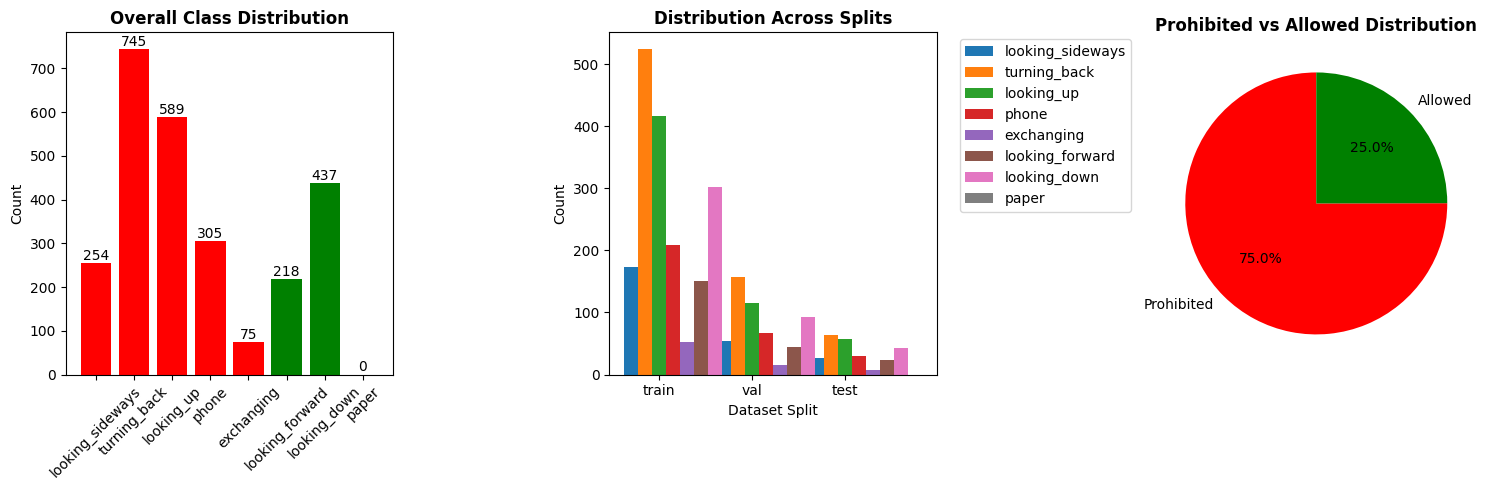

Dataset analysis complete.


In [30]:
# Now that the dataset structure has been validated, we can analyze the dataset.
if dataset_ready:
    class_counts, split_counts = analyze_dataset()
    print("Dataset analysis complete.")
else:
    print("Dataset is not ready for analysis. Please ensure the splitting and validation steps are completed.")

In [23]:
def analyze_dataset():
    print("📊 Analyzing dataset...")

    with open(os.path.join(config.DATASET_PATH, 'data.yaml'), 'r') as f:
        data_config = yaml.safe_load(f)

    splits = ['train', 'val', 'test']
    class_counts = {cls: 0 for cls in config.ALL_CLASSES}
    split_counts = {}

    for split in splits:
        labels_dir = os.path.join(config.DATASET_PATH, split, 'labels')
        split_counts[split] = {cls: 0 for cls in config.ALL_CLASSES}

        if os.path.exists(labels_dir):
            for label_file in os.listdir(labels_dir):
                if label_file.endswith('.txt'):
                    with open(os.path.join(labels_dir, label_file), 'r') as f:
                        for line in f:
                            if line.strip():
                                try:
                                    class_id = int(line.split()[0])
                                    if class_id < len(config.ALL_CLASSES):
                                        class_name = config.ALL_CLASSES[class_id]
                                        class_counts[class_name] += 1
                                        split_counts[split][class_name] += 1
                                except (ValueError, IndexError):
                                    continue

    print("\n📈 Dataset Statistics:")
    print(f"Total annotations: {sum(class_counts.values())}")

    for split in splits:
        print(f"\n{split.upper()} Split:")
        total_split = sum(split_counts[split].values())
        print(f"  Total annotations: {total_split}")
        for cls in config.ALL_CLASSES:
            count = split_counts[split][cls]
            if count > 0:
                percentage = (count / total_split * 100) if total_split > 0 else 0
                print(f"  {cls}: {count} ({percentage:.1f}%)") # Removed the extra text from f-string

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    colors = ['red' if cls in config.PROHIBITED_CLASSES else 'green' for cls in classes]

    bars = plt.bar(classes, counts, color=colors)
    plt.title('Overall Class Distribution', fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylabel('Count')

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(count), ha='center', va='bottom')

    plt.subplot(1, 3, 2)
    x = np.arange(len(splits))
    width = 0.15

    for i, cls in enumerate(config.ALL_CLASSES):
        split_data = [split_counts[split][cls] for split in splits]
        plt.bar(x + i*width, split_data, width, label=cls)

    plt.title('Distribution Across Splits', fontweight='bold')
    plt.xlabel('Dataset Split')
    plt.ylabel('Count')
    plt.xticks(x + width*2, splits)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 3, 3)
    prohibited_total = sum([class_counts[cls] for cls in config.PROHIBITED_CLASSES])
    allowed_total = sum([class_counts[cls] for cls in config.ALLOWED_CLASSES])

    categories = ['Prohibited', 'Allowed']
    totals = [prohibited_total, allowed_total]
    colors = ['red', 'green']

    plt.pie(totals, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Prohibited vs Allowed Distribution', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return class_counts, split_counts

# The call to analyze_dataset() is moved to a new cell after the dataset is fully prepared.

## Update Config and Run Dataset Split



In [31]:
import os
import shutil
import random
import yaml

config.DATASET_PATH = '/content/malpractice_dataset'
print(f"Updated config.DATASET_PATH to: {config.DATASET_PATH}")

class DatasetSplit:
    def __init__(self, raw_images_dir, raw_labels_dir, output_dir, class_names, split_ratios=(0.7, 0.2, 0.1), seed=42):
        self.raw_images_dir = raw_images_dir
        self.raw_labels_dir = raw_labels_dir
        self.output_dir = output_dir
        self.class_names = class_names
        self.split_ratios = split_ratios
        self.seed = seed
        random.seed(self.seed)

        self.splits = {'train': [], 'val': [], 'test': []}
        self.split_dirs = {'train': os.path.join(output_dir, 'train'),
                           'val': os.path.join(output_dir, 'val'),
                           'test': os.path.join(output_dir, 'test')}

    def _create_split_directories(self):
        for split_name in self.splits.keys():
            os.makedirs(os.path.join(self.split_dirs[split_name], 'images'), exist_ok=True)
            os.makedirs(os.path.join(self.split_dirs[split_name], 'labels'), exist_ok=True)
        print("Created split directories (train, val, test) with images/labels subdirectories.")

    def _split_and_copy_files(self):
        all_image_files = [f for f in os.listdir(self.raw_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(all_image_files)

        num_images = len(all_image_files)
        train_count = int(num_images * self.split_ratios[0])
        val_count = int(num_images * self.split_ratios[1])
        test_count = num_images - train_count - val_count

        self.splits['train'] = all_image_files[:train_count]
        self.splits['val'] = all_image_files[train_count : train_count + val_count]
        self.splits['test'] = all_image_files[train_count + val_count :]

        print(f"Splitting {num_images} images: Train={len(self.splits['train'])}, Val={len(self.splits['val'])}, Test={len(self.splits['test'])}")

        for split_name, files_in_split in self.splits.items():
            dest_images_dir = os.path.join(self.split_dirs[split_name], 'images')
            dest_labels_dir = os.path.join(self.split_dirs[split_name], 'labels')
            for img_file in files_in_split:
                shutil.copy(os.path.join(self.raw_images_dir, img_file), os.path.join(dest_images_dir, img_file))

                label_file = os.path.splitext(img_file)[0] + '.txt'
                src_label_path = os.path.join(self.raw_labels_dir, label_file)
                if os.path.exists(src_label_path):
                    shutil.copy(src_label_path, os.path.join(dest_labels_dir, label_file))
                else:
                    print(f"Warning: Label file {label_file} not found for image {img_file}")
        print("Files copied to respective split directories.")

    def _generate_data_yaml(self):
        data_yaml_path = os.path.join(self.output_dir, 'data.yaml')
        data_config = {
            'path': self.output_dir,
            'train': 'train/images',
            'val': 'val/images',
            'test': 'test/images',
            'nc': len(self.class_names),
            'names': self.class_names
        }
        with open(data_yaml_path, 'w') as f:
            yaml.dump(data_config, f, sort_keys=False)
        print(f"Generated data.yaml at: {data_yaml_path}")

    def run_split(self):
        print(f"\nStarting data splitting process to {self.output_dir}")
        self._create_split_directories()
        self._split_and_copy_files()
        self._generate_data_yaml()
        print("Data splitting complete.")

data_splitter = DatasetSplit(
    raw_images_dir=local_raw_images_dir,
    raw_labels_dir=local_raw_labels_dir,
    output_dir=config.DATASET_PATH,
    class_names=config.ALL_CLASSES,
    split_ratios=(0.7, 0.2, 0.1)
)
data_splitter.run_split()

Updated config.DATASET_PATH to: /content/malpractice_dataset

Starting data splitting process to /content/malpractice_dataset
Created split directories (train, val, test) with images/labels subdirectories.
Splitting 140 images: Train=98, Val=28, Test=14
Files copied to respective split directories.
Generated data.yaml at: /content/malpractice_dataset/data.yaml
Data splitting complete.


## Validate Dataset Structure



In [26]:
dataset_ready = setup_dataset_structure()
print(f"Dataset structure validation status: {dataset_ready}")

Setting up dataset structure...
Dataset structure validated!
Dataset structure validation status: True


## Model Training



In [32]:
class MalpracticeConfig:
  PROHIBITED_CLASSES = ['looking_sideways', 'turning_back', 'looking_up', 'phone', 'exchanging']
  ALLOWED_CLASSES = ['looking_forward', 'looking_down', 'paper']

  ALL_CLASSES = PROHIBITED_CLASSES + ALLOWED_CLASSES

  BATCH_SIZE = 16
  EPOCHS = 120
  IMG_SIZE = 640
  CONFIDENCE_THRESHOLD = 0.5

  PROHIBITED_WEIGHT = 1.0
  MALPRACTICE_THRESHOLD = 0.3

  DATASET_PATH = "/content/malpractice_dataset"
  PROJECT_NAME = "malpractice-detection-v1"

config = MalpracticeConfig()

In [33]:
def train_malpractice_model():
    """Train YOLOv8 model for malpractice detection"""
    print("🚀 Starting Malpractice Detection Model Training...")

    # Clear GPU cache
    torch.cuda.empty_cache()

    # Load model
    model = YOLO('yolov8s.pt')  # Using small model for faster training

    # Train the model
    results = model.train(
        data=os.path.join(config.DATASET_PATH, 'data.yaml'),
        epochs=config.EPOCHS,
        imgsz=config.IMG_SIZE,
        batch=config.BATCH_SIZE,
        patience=15,
        save=True,
        project=config.PROJECT_NAME,
        name='train',
        exist_ok=True,
        verbose=True,
        cos_lr=True,  # Cosine learning rate scheduler
        lr0=0.01,     # Initial learning rate
        lrf=0.01,     # Final learning rate
        momentum=0.937,
        weight_decay=0.0005,
        warmup_epochs=3.0,
        warmup_momentum=0.8,
        box=7.5,      # Box loss gain
        cls=0.5,      # Class loss gain
        dfl=1.5,      # Distribution Focal Loss gain
    )

    print("✅ Training completed!")
    return model, results

# Start training
if dataset_ready:
    print("🎯 Beginning model training...")
    trained_model, training_results = train_malpractice_model()
else:
    trained_model, training_results = None, None

🎯 Beginning model training...
🚀 Starting Malpractice Detection Model Training...
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/malpractice_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=F

In [34]:
if dataset_ready:
    print("🎯 Beginning model training...")
    trained_model, results_df = train_malpractice_model()
else:
    print("❌ Dataset not ready. Please fix dataset structure before training.")
    trained_model, results_df = None, None

🎯 Beginning model training...
🚀 Starting Malpractice Detection Model Training...
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/malpractice_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=F

## Model Evaluation Visualizations



In [35]:
def evaluate_model(model):
    print("🧪 Evaluating model performance...")

    metrics = model.val(
        data=os.path.join(config.DATASET_PATH, 'data.yaml'),
        split='test',
        save_json=True,
        conf=config.CONFIDENCE_THRESHOLD
    )

    print(f"\n📊 Validation Metrics:")
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")

    print(f"\n🎯 Class-wise Performance:")
    for i, class_name in enumerate(config.ALL_CLASSES):
        if i < len(metrics.box.ap_class_index):
            class_idx_in_config = metrics.box.ap_class_index[i]
            if class_idx_in_config < len(config.ALL_CLASSES):
                print(f"{config.ALL_CLASSES[class_idx_in_config]:<20}: "
                      f"mAP50: {metrics.box.ap50[i].item():.4f}, "
                      f"mAP: {metrics.box.ap[i].item():.4f}")

    return metrics

if trained_model:
    metrics = evaluate_model(trained_model)
else:
    metrics = None

🧪 Evaluating model performance...
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 98.9±173.7 MB/s, size: 50.7 KB)
val: Scanning /content/malpractice_dataset/test/labels... 14 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 14/14 640.7it/s 0.0s
val: New cache created: /content/malpractice_dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.8it/s 0.5s
                   all         14        250      0.891      0.769       0.85      0.705
      looking_sideways         12         26      0.846      0.846      0.882      0.846
          turning_back         13         63      0.966      0.889       0.94      0.791
            looking_up         12         57      0.904      0.825      0.878      0.734
                 phone         10

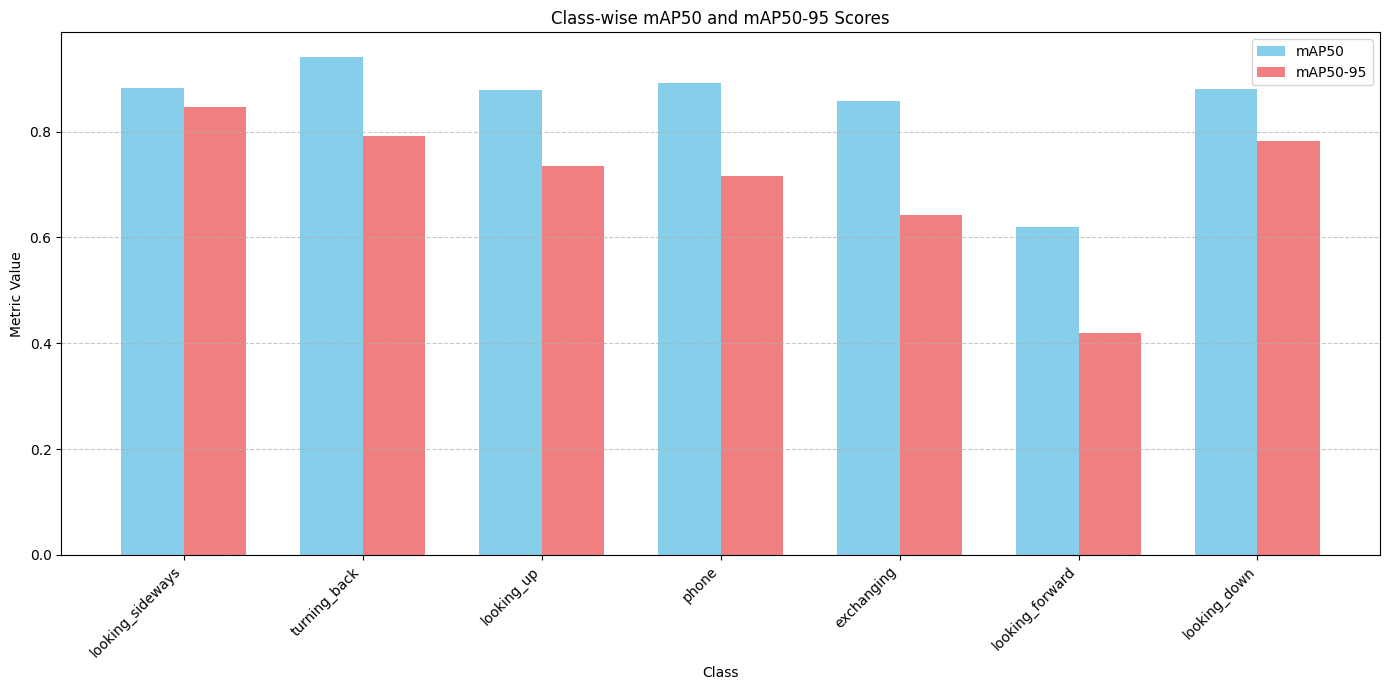

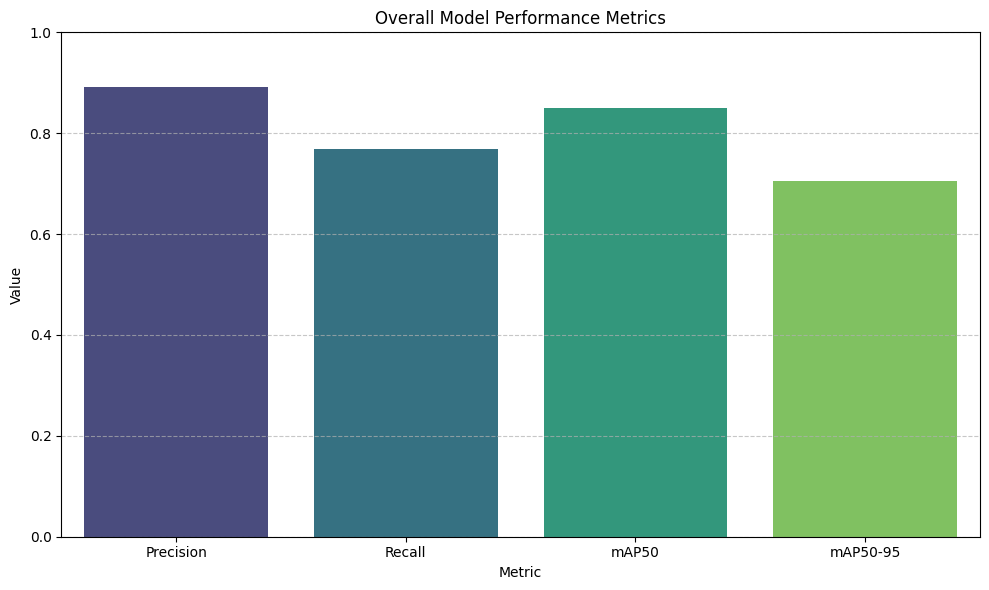

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

if metrics:
    class_metrics = {
        'Class': [],
        'mAP50': [],
        'mAP50-95': []
    }
    for i, class_name in enumerate(config.ALL_CLASSES):
        if i < len(metrics.box.ap_class_index):
            class_idx_in_config = metrics.box.ap_class_index[i]
            if class_idx_in_config < len(config.ALL_CLASSES):
                class_metrics['Class'].append(config.ALL_CLASSES[class_idx_in_config])
                class_metrics['mAP50'].append(metrics.box.ap50[i].item())
                class_metrics['mAP50-95'].append(metrics.box.ap[i].item())

    df_class_metrics = pd.DataFrame(class_metrics)

    plt.figure(figsize=(14, 7))
    bar_width = 0.35
    index = range(len(df_class_metrics['Class']))

    plt.bar(index, df_class_metrics['mAP50'], bar_width, label='mAP50', color='skyblue')
    plt.bar([i + bar_width for i in index], df_class_metrics['mAP50-95'], bar_width, label='mAP50-95', color='lightcoral')

    plt.xlabel('Class')
    plt.ylabel('Metric Value')
    plt.title('Class-wise mAP50 and mAP50-95 Scores')
    plt.xticks([i + bar_width / 2 for i in index], df_class_metrics['Class'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    overall_metrics_data = {
        'Metric': ['Precision', 'Recall', 'mAP50', 'mAP50-95'],
        'Value': [metrics.box.mp.item(), metrics.box.mr.item(), metrics.box.map50, metrics.box.map]
    }
    df_overall_metrics = pd.DataFrame(overall_metrics_data)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Value', data=df_overall_metrics, palette='viridis')
    plt.ylim(0, 1)
    plt.title('Overall Model Performance Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Model metrics not available. Please ensure the model was trained and evaluated.")

## Malpractice Detection System Class

This class encapsulates the logic for running the malpractice detection model, analyzing detections, and identifying prohibited behaviors within images or a dataset split.

In [37]:
import os
import cv2
import numpy as np
from typing import List, Dict
from ultralytics import YOLO

class MalpracticeDetectionSystem:
    def __init__(self, model_path: str, config: 'MalpracticeConfig', confidence_threshold: float = 0.5):
        self.model = YOLO(model_path)
        self.config = config
        self.confidence_threshold = confidence_threshold

        self.class_names = config.ALL_CLASSES
        self.class_id_to_name = {i: name for i, name in enumerate(self.class_names)}
        self.prohibited_class_ids = [self.class_names.index(c) for c in config.PROHIBITED_CLASSES if c in self.class_names]

    def _run_inference(self, image_path: str) -> List[Dict]:
        results = self.model(image_path, conf=self.confidence_threshold, verbose=False)
        detections = []
        for r in results:
            for *xyxy, conf, cls in r.boxes.data:
                class_name = self.class_id_to_name.get(int(cls.item()), "unknown")
                detections.append({
                    'bbox': [int(x) for x in xyxy],
                    'confidence': conf.item(),
                    'class_id': int(cls.item()),
                    'class_name': class_name
                })
        return detections

    def _calculate_malpractice_score(self, detections: List[Dict]) -> float:
        prohibited_count = 0
        total_objects = len(detections)

        for det in detections:
            if det['class_id'] in self.prohibited_class_ids:
                prohibited_count += 1

        if total_objects == 0:
            return 0.0

        return prohibited_count / total_objects

    def analyze_image(self, image_path: str, visualize: bool = False, output_dir: str = None):
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not load image from {image_path}")
            return None, 0.0, None

        detections = self._run_inference(image_path)
        malpractice_score = self._calculate_malpractice_score(detections)

        annotated_img = None
        if visualize:
            annotated_img = img.copy()
            for det in detections:
                x1, y1, x2, y2 = det['bbox']
                class_name = det['class_name']
                confidence = det['confidence']

                color = (0, 0, 255) if det['class_id'] in self.prohibited_class_ids else (0, 255, 0)
                label = f"{class_name} {confidence:.2f}"

                cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(annotated_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

            score_text = f"Malpractice Score: {malpractice_score:.2f}"
            cv2.putText(annotated_img, score_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

            if output_dir:
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, os.path.basename(image_path))
                cv2.imwrite(output_path, annotated_img)
                print(f"Annotated image saved to {output_path}")

        return detections, malpractice_score, annotated_img

    def analyze_dataset_split(self, split: str = 'val', visualize_output_dir: str = None) -> Dict:
        print(f"\n🚀 Analyzing '{split}' dataset split for malpractice...")
        split_images_dir = os.path.join(self.config.DATASET_PATH, split, 'images')

        if not os.path.exists(split_images_dir):
            print(f"Error: Image directory for split '{split}' not found at {split_images_dir}")
            return {}

        all_image_files = [os.path.join(split_images_dir, f) for f in os.listdir(split_images_dir)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if not all_image_files:
            print(f"No images found in the '{split}' split at {split_images_dir}")
            return {}

        total_images = len(all_image_files)
        total_malpractice_score = 0.0
        images_with_malpractice = 0
        malpractice_details = []

        for i, image_path in enumerate(all_image_files):
            print(f"Processing image {i+1}/{total_images}: {os.path.basename(image_path)}")
            detections, score, _ = self.analyze_image(image_path, visualize=False)

            total_malpractice_score += score
            if score > self.config.MALPRACTICE_THRESHOLD:
                images_with_malpractice += 1
                malpractice_details.append({'image': os.path.basename(image_path), 'score': score, 'detections': detections})

            if visualize_output_dir and score > self.config.MALPRACTICE_THRESHOLD:
                _, _, annotated_img = self.analyze_image(image_path, visualize=True, output_dir=visualize_output_dir)

        avg_malpractice_score = total_malpractice_score / total_images if total_images > 0 else 0.0
        percentage_images_with_malpractice = (images_with_malpractice / total_images * 100) if total_images > 0 else 0.0

        results = {
            'split': split,
            'total_images': total_images,
            'avg_malpractice_score': avg_malpractice_score,
            'images_with_malpractice_count': images_with_malpractice,
            'percentage_images_with_malpractice': percentage_images_with_malpractice,
            'malpractice_threshold': self.config.MALPRACTICE_THRESHOLD,
            'malpractice_details': malpractice_details
        }

        print(f"\n--- Analysis for '{split}' Split Complete ---")
        print(f"Total Images Processed: {results['total_images']}")
        print(f"Average Malpractice Score: {results['avg_malpractice_score']:.4f}")
        print(f"Images above Malpractice Threshold ({self.config.MALPRACTICE_THRESHOLD:.2f}): {results['images_with_malpractice_count']} ({results['percentage_images_with_malpractice']:.2f}%)")

        return results

### Instantiate and Run Malpractice Detection System on Validation Set

Now that the `MalpracticeDetectionSystem` class is defined, let's instantiate it with our trained model and configuration, and then run it on the validation dataset split to assess malpractice.

Streaming output truncated to the last 5000 lines.
            142,
            150,
            203
          ],
          "confidence": 0.7801247239112854,
          "class_id": 2,
          "class_name": "looking_up"
        },
        {
          "bbox": [
            235,
            323,
            304,
            409
          ],
          "confidence": 0.7629901766777039,
          "class_id": 6,
          "class_name": "looking_down"
        },
        {
          "bbox": [
            287,
            182,
            326,
            241
          ],
          "confidence": 0.7296010851860046,
          "class_id": 1,
          "class_name": "turning_back"
        },
        {
          "bbox": [
            172,
            224,
            220,
            289
          ],
          "confidence": 0.6187570691108704,
          "class_id": 1,
          "class_name": "turning_back"
        },
        {
          "bbox": [
            200,
            147,
            236,
 

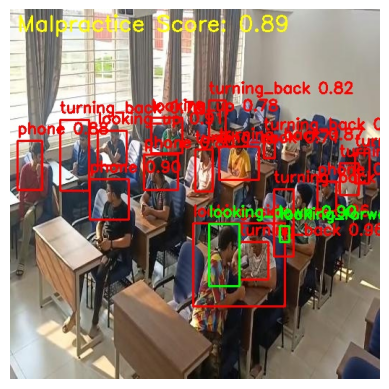

Displaying WhatsApp-Video-2025-11-08-at-18_11_55_36bf848c_mp4-0009_jpg.rf.48cd0726cc8f15ea7eb2a2ab06f0ab3d.jpg


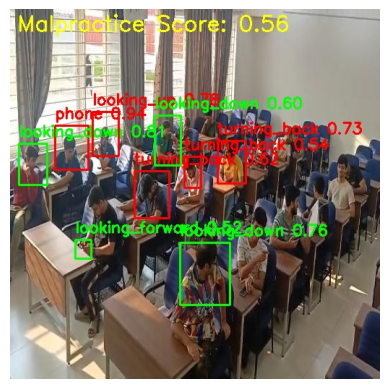

Displaying WhatsApp-Video-2025-11-08-at-18_11_55_36bf848c_mp4-0073_jpg.rf.f0b0bee2e80c0b4bbc3f1fa767e217fe.jpg


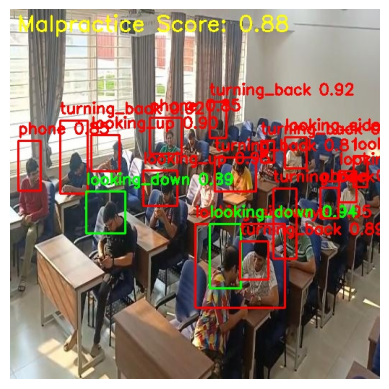

Displaying WhatsApp-Video-2025-11-08-at-18_11_55_36bf848c_mp4-0005_jpg.rf.831c132dbeb7a4da3af8279cdce62e9f.jpg


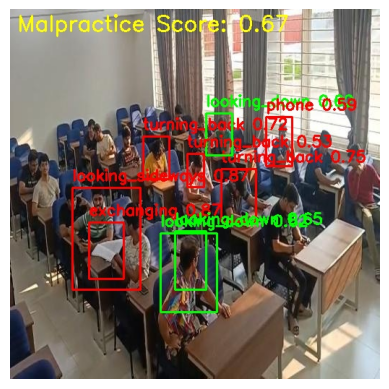

Displaying WhatsApp-Video-2025-11-08-at-18_11_55_36bf848c_mp4-0014_jpg.rf.2878cc455f45e65939c12afc9ce76e26.jpg


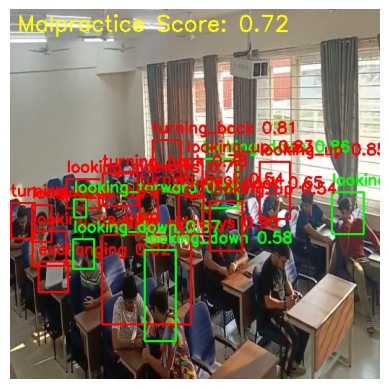

In [38]:
# Ensure trained_model is available (from previous training step)
import os
if 'trained_model' in locals() and trained_model is not None:
    # Construct the path to the best trained model weights
    # Based on Ultralytics default saving, it's usually in runs/detect/project_name/weights/best.pt
    model_weights_path = os.path.join(
        '/content',
        config.PROJECT_NAME, # This is 'malpractice-detection-v1'
        'train', # Default directory created by model.train()
        'weights',
        'best.pt' # Name of the best weights file
    )

    malpractice_detector = MalpracticeDetectionSystem(
        model_path=model_weights_path, # Use the constructed path to the best trained model
        config=config,
        confidence_threshold=config.CONFIDENCE_THRESHOLD
    )

    # Analyze the validation dataset split
    # Optionally, provide a directory to save visualized images where malpractice is detected
    visualize_malpractice_output_dir = '/content/malpractice_detections_val'
    val_malpractice_results = malpractice_detector.analyze_dataset_split(
        split='val',
        visualize_output_dir=visualize_malpractice_output_dir
    )

    print("\nValidation Malpractice Analysis Results:")
    print(json.dumps(val_malpractice_results, indent=2))

    # Optionally, display some of the annotated images
    if os.path.exists(visualize_malpractice_output_dir):
        print(f"\nDisplaying a few annotated images from {visualize_malpractice_output_dir}:")
        image_files = [os.path.join(visualize_malpractice_output_dir, f)
                       for f in os.listdir(visualize_malpractice_output_dir)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for i, img_file in enumerate(image_files[:5]): # Display up to 5 images
            print(f"Displaying {os.path.basename(img_file)}")
            img = cv2.imread(img_file)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

else:
    print("Error: Trained model not found. Please ensure the model training step was completed successfully.")

## Confusion Matrix

## Confusion Matrix

Generating confusion matrix for 14 test images...
Finished processing test images.


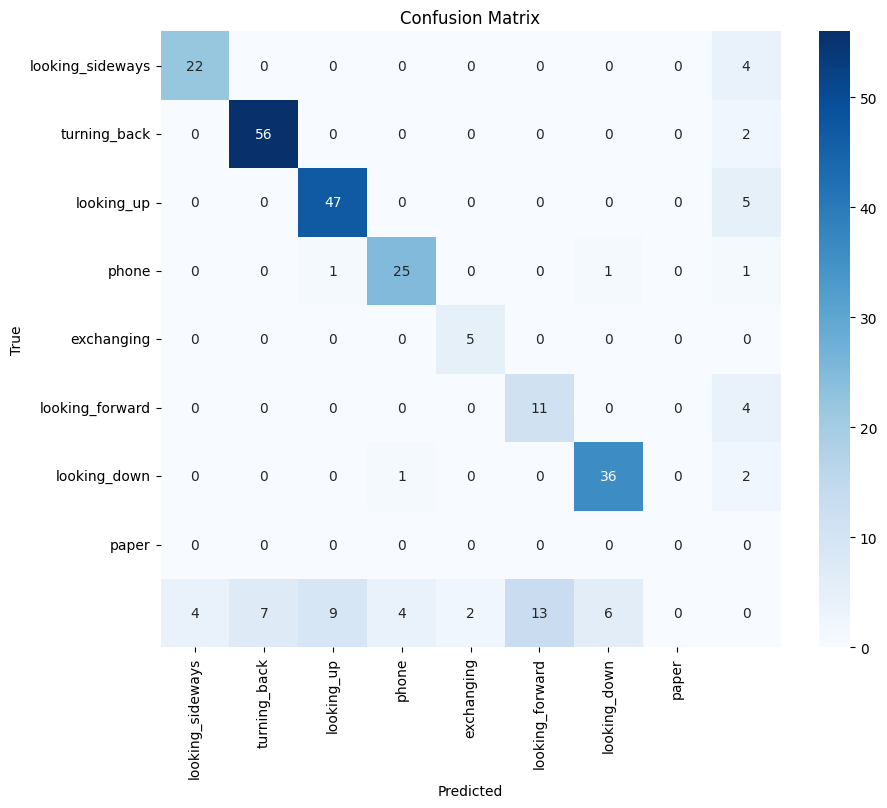

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

y_true = []
y_pred = []

if 'trained_model' in locals() and trained_model is not None:
    model_weights_path = os.path.join(
        '/content',
        config.PROJECT_NAME,
        'train',
        'weights',
        'best.pt'
    )
    malpractice_detector = MalpracticeDetectionSystem(
        model_path=model_weights_path,
        config=config,
        confidence_threshold=config.CONFIDENCE_THRESHOLD
    )

    test_images_dir = os.path.join(config.DATASET_PATH, 'test', 'images')
    test_labels_dir = os.path.join(config.DATASET_PATH, 'test', 'labels')

    if not os.path.exists(test_images_dir):
        print(f"Error: Test images directory not found at {test_images_dir}")
    elif not os.path.exists(test_labels_dir):
        print(f"Error: Test labels directory not found at {test_labels_dir}")
    else:
        all_test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not all_test_images:
            print(f"No images found in the test set at {test_images_dir}")
        else:
            print(f"Generating confusion matrix for {len(all_test_images)} test images...")
            for i, image_filename in enumerate(all_test_images):
                image_path = os.path.join(test_images_dir, image_filename)
                label_filename = os.path.splitext(image_filename)[0] + '.txt'
                label_path = os.path.join(test_labels_dir, label_filename)

                if not os.path.exists(label_path):
                    print(f"Warning: Skipping {image_filename} as no corresponding label file was found.")
                    continue

                ground_truth_classes_in_image = []
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if parts:
                            gt_class_id = int(parts[0])
                            ground_truth_classes_in_image.append(config.ALL_CLASSES[gt_class_id])

                detections, _, _ = malpractice_detector.analyze_image(image_path, visualize=False)
                predicted_classes_in_image = [det['class_name'] for det in detections]

                unique_gt_classes = sorted(list(set(ground_truth_classes_in_image)))
                unique_pred_classes = sorted(list(set(predicted_classes_in_image)))

                for cls_name in config.ALL_CLASSES:
                    is_gt = 1 if cls_name in unique_gt_classes else 0
                    is_pred = 1 if cls_name in unique_pred_classes else 0

                    y_true.append(is_gt)
                    y_pred.append(is_pred)
            print("Finished processing test images.")
else:
    print("Error: Trained model not found. Please ensure the model training step was completed successfully.")


class_to_int = {name: i for i, name in enumerate(config.ALL_CLASSES)}
int_to_class = {i: name for i, name in enumerate(config.ALL_CLASSES)}


all_gt_ids = []
all_pred_ids = []

if 'malpractice_detector' in locals():
    for i, image_filename in enumerate(all_test_images):
        image_path = os.path.join(test_images_dir, image_filename)
        label_filename = os.path.splitext(image_filename)[0] + '.txt'
        label_path = os.path.join(test_labels_dir, label_filename)

        if not os.path.exists(label_path):
            continue

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    gt_class_id = int(parts[0])
                    all_gt_ids.append(gt_class_id)

        detections, _, _ = malpractice_detector.analyze_image(image_path, visualize=False)
        for det in detections:
            all_pred_ids.append(det['class_id'])

if metrics and hasattr(metrics, 'confusion_matrix') and metrics.confusion_matrix.matrix is not None:
    cm = metrics.confusion_matrix.matrix
    if isinstance(cm, torch.Tensor):
        cm = cm.cpu().numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=config.ALL_CLASSES,
                yticklabels=config.ALL_CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Could not retrieve confusion matrix from evaluation metrics. Proceeding with a simplified version.")
    if len(y_true) > 0 and len(y_pred) > 0:
        y_true_int = [class_to_int[label] for label in y_true]
        y_pred_int = [class_to_int[label] for label in y_pred]

        cm = confusion_matrix(y_true_int, y_pred_int, labels=list(range(len(config.ALL_CLASSES))))

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                    xticklabels=config.ALL_CLASSES,
                    yticklabels=config.ALL_CLASSES)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Simplified Confusion Matrix (Class Presence/Absence)')
        plt.show()
    else:
        print("Not enough data to generate a simplified confusion matrix.")

## Training and Validation Loss Curves

Let's visualize the training and validation losses over epochs to understand the model's learning progress and identify potential overfitting or underfitting.

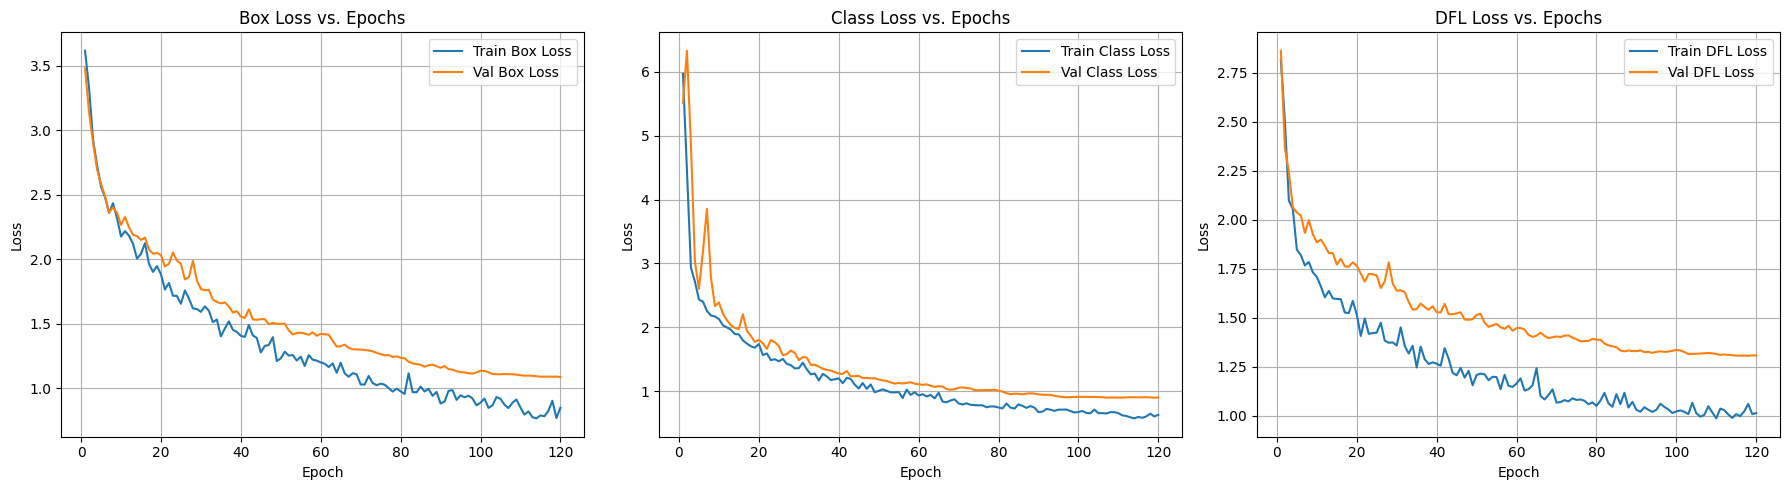

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import os

results_df = None # Initialize results_df

# Check if training_results (from model.train()) and config are available
# The training results are typically saved in /content/<PROJECT_NAME>/train/results.csv
if 'training_results' in locals() and training_results is not None and 'config' in locals():
    results_dir = os.path.join('/content', config.PROJECT_NAME, 'train')
    results_csv_path = os.path.join(results_dir, 'results.csv')

    if os.path.exists(results_csv_path):
        results_df = pd.read_csv(results_csv_path)
    else:
        print(f"Error: results.csv not found at expected path: {results_csv_path}")
else:
    print("Training results object ('training_results') or config not found. Please ensure the model training step was completed successfully.")


if results_df is not None:
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
    plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss')
    plt.title('Box Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Train Class Loss')
    plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Val Class Loss')
    plt.title('Class Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='Train DFL Loss')
    plt.plot(results_df['epoch'], results_df['val/dfl_loss'], label='Val DFL Loss')
    plt.title('DFL Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Training loss curves could not be plotted due to missing results data.")